# Final Year Project Data Analysis

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import os
import random
from tqdm import tqdm

In [103]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

todos:
- load (done)
- visualize images (done)
- resize (done)
- group/cluster datasets (by using magnitude of pixel and by noise level)
- (i believe this will not really work) use simpler models (SVM) to predict
- (if we have time) check distribution of other datasets too

## Loading Data

In [8]:
def load_images_in_a_directory(directory_path):
    images = []
    print(os.listdir(directory_path))
    for filename in os.listdir(directory_path):
        if filename.endswith("png") or filename.endswith("jpg"):
            image_path = os.path.join(directory_path, filename)
            image = Image.open(image_path)
            images.append(image)
    
    return images

In [12]:
os.listdir("SIE_Dataset/Real_world_images")

['Blowing_sand', 'Floating_dust', 'Sandstorm', 'Strong_sandstorm']

In [13]:
# loading ground truth images
path = "SIE_Dataset/Synthetic_images/Ground_truth"
gt_images = load_images_in_a_directory(path)

# loading corrupted images
path = "SIE_Dataset/Synthetic_images/Sand_dust_images"
dust_images = load_images_in_a_directory(path)

['001.jpg', '002.jpg', '003.jpg', '004.jpg', '005.jpg', '006.jpg', '007.jpg', '008.jpg', '009.jpg', '010.jpg', '011.jpg', '012.jpg', '013.jpg', '014.jpg', '015.jpg', '016.jpg', '017.jpg', '018.jpg', '019.jpg', '020.jpg', '021.jpg', '022.jpg', '023.jpg', '024.jpg', '025.jpg', '026.jpg', '027.jpg', '028.jpg', '029.jpg', '030.jpg', '031.jpg', '032.jpg', '033.jpg', '034.jpg', '035.jpg', '036.jpg', '037.jpg', '038.jpg', '039.jpg', '040.jpg', '041.jpg', '042.jpg', '043.jpg', '044.jpg', '045.jpg', '046.jpg', '047.jpg', '048.jpg', '049.jpg', '050.jpg', '051.jpg', '052.jpg', '053.jpg', '054.jpg', '055.jpg', '056.jpg', '057.jpg', '058.jpg', '059.jpg', '060.jpg', '061.jpg', '062.jpg', '063.jpg', '064.jpg', '065.jpg', '066.jpg', '067.jpg', '068.jpg', '069.jpg', '070.jpg', '071.jpg', '072.jpg', '073.jpg', '074.jpg', '075.jpg', '076.jpg', '077.jpg', '078.jpg', '079.jpg', '080.jpg', '081.jpg', '082.jpg', '083.jpg', '084.jpg', '085.jpg', '086.jpg', '087.jpg', '088.jpg', '089.jpg', '090.jpg', '091.jpg'

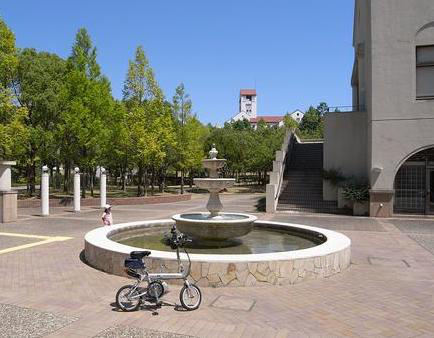

In [19]:
gt_images[0]

In [14]:
len(gt_images) == len(dust_images)

True

## Visualizing Raw Images

Note that we have varing seizes of images. We will ensure that all images have the same shape.

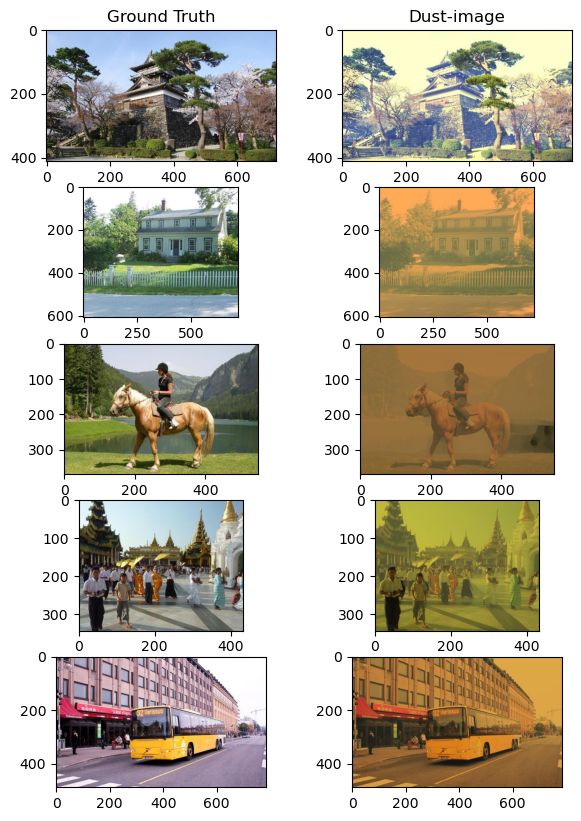

In [28]:
np.random.seed(123)
random_img_indices = np.random.randint(0, len(gt_images), size=(10, ))

fig = plt.figure(figsize=(7, 20))

for i in range(1, 11, 2):
    ax1 = fig.add_subplot(10, 2, i)
    ax1.imshow(gt_images[random_img_indices[i-1]])
    ax2 = fig.add_subplot(10, 2, i+1)
    ax2.imshow(dust_images[random_img_indices[i-1]])
    
    if i == 1:
        ax1.set_title("Ground Truth")
        ax2.set_title("Dust-image")

## Resizing Images

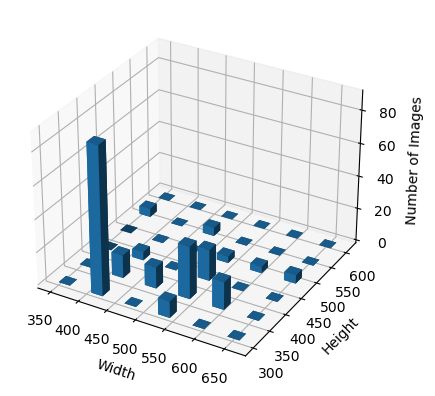

In [67]:
widths = [image.width for image in gt_images]
heights = [image.height for image in gt_images]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
hist, xedges, yedges = np.histogram2d(widths, heights, bins=6, range=[[350, 700], [300, 650]])

# position of bins
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# size of bars
dx = dy = 20 * np.ones_like(zpos)
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')
ax.set_xlabel("Width")
ax.set_ylabel("Height")
ax.set_zlabel("Number of Images")

plt.show()

In [77]:
i_max, j_max = np.unravel_index(hist.argmax(axis=None), hist.shape)
most_frequent_width = (xedges[i_max] + xedges[i_max+1]) / 2
most_frequent_height = (yedges[j_max] + yedges[j_max+1]) / 2
print(f"The average width and height of most frequent images are: {most_frequent_width}, and {most_frequent_height}")

The average width and height of most frequent images are: 437.5, and 329.16666666666663


We see that a large portion of images have a shape of approximately 440 by 330. Therefore,we will crop images that are bigger than these width and height. Since we are not dealing with classification task, but rather removing noises from the images, we can crop different parts of images, with the same size.For smaller images, we will stretch first and then apply cropping.

In [96]:
def crop_image(image, w_threshold, h_threshold):
    assert image.width >= w_threshold and image.height >= h_threshold, "to crop, image size must be bigger than or equal to the threshold values"
    
    # choose top and right randomly -> bottom and left automallycally determined
    top = random.randint(0, image.height - h_threshold)  # inclusive
    left = random.randint(0, image.width - w_threshold)
    
    bottom = top + h_threshold
    right = left + w_threshold
    
    return image.crop((left, top, right, bottom))
    

def is_image_smaller_than_threshold(image, w_threshold, h_threshold) -> bool:
    return image.width < w_threshold or image.height < h_threshold

def stretch_image(image, w_threshold, h_threshold):
    aspect_ratio = h_threshold / w_threshold
    
    if h_threshold - image.height < 0:
        resize_based_on_width = True
    elif w_threshold - image.width < 0:
        resize_based_on_width = False
    else:
        # resize based on whichever the difference is smaller
        resize_based_on_width = np.argmin([w_threshold - image.width, h_threshold - image.height])
        
    if resize_based_on_width:
        new_w = w_threshold
        new_h = int(new_w * aspect_ratio)
    else:
        new_h = h_threshold
        new_w = int(new_h / aspect_ratio)
    
    return image.resize((new_w, new_h))

In [100]:
def resize_images(images, w_threshold, h_threshold):
    resized_images = []
    for image in tqdm(images):
        if is_image_smaller_than_threshold(image, w_threshold, h_threshold):
            image = stretch_image(image, w_threshold, h_threshold)
        
        new_image = crop_image(image, w_threshold, h_threshold)
        resized_images.append(new_image)
    
    return resized_images

In [101]:
W_THRESHOLD = 440
H_THRESHOLD = 330

# apply resizing to gt_images and dust images
resized_gt_images = resize_images(gt_images, W_THRESHOLD, H_THRESHOLD)
resized_dust_images = resize_images(dust_images, W_THRESHOLD, H_THRESHOLD)

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 297.47it/s]


We check that all images have the size = 440*330

In [102]:
resized_gt_images

[<PIL.Image.Image image mode=RGB size=440x330>,
 <PIL.Image.Image image mode=RGB size=440x330>,
 <PIL.Image.Image image mode=RGB size=440x330>,
 <PIL.Image.Image image mode=RGB size=440x330>,
 <PIL.Image.Image image mode=RGB size=440x330>,
 <PIL.Image.Image image mode=RGB size=440x330>,
 <PIL.Image.Image image mode=RGB size=440x330>,
 <PIL.Image.Image image mode=RGB size=440x330>,
 <PIL.Image.Image image mode=RGB size=440x330>,
 <PIL.Image.Image image mode=RGB size=440x330>,
 <PIL.Image.Image image mode=RGB size=440x330>,
 <PIL.Image.Image image mode=RGB size=440x330>,
 <PIL.Image.Image image mode=RGB size=440x330>,
 <PIL.Image.Image image mode=RGB size=440x330>,
 <PIL.Image.Image image mode=RGB size=440x330>,
 <PIL.Image.Image image mode=RGB size=440x330>,
 <PIL.Image.Image image mode=RGB size=440x330>,
 <PIL.Image.Image image mode=RGB size=440x330>,
 <PIL.Image.Image image mode=RGB size=440x330>,
 <PIL.Image.Image image mode=RGB size=440x330>,
 <PIL.Image.Image image mode=RGB size=44

## Simple Clustering

In [ ]:
gt_arrays = []

In [ ]:
kmeans = KMeans(n_clusters=5, n_init=5)
StandardScalar()
kmeans.fit()